In [1]:
%matplotlib inline
import os

import rasterio
import random
import json
import sys
import datacube
import matplotlib
import geopandas as gpd
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from geopy.geocoders import Nominatim 
from shapely import speedups
from shapely.geometry import Point, Polygon, LineString
from shapely.ops import triangulate
from shapely.strtree import STRtree
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from deafrica_tools.plotting import display_map, map_shapefile, plot_lulc, rgb
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.spatial import subpixel_contours
from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.areaofinterest import define_area
from deafrica_tools.coastal import tidal_tag
from deafrica_tools.dask import create_local_dask_cluster
from datacube.utils.geometry import Geometry
from deafrica_tools.spatial import xr_rasterize

import matplotlib.colors as mcolors

In [2]:
from datacube.utils.geometry import Geometry





In [3]:
create_local_dask_cluster()

INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:39913
INFO:distributed.scheduler:  dashboard at:            127.0.0.1:8787
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:34945'
2024-06-21 11:53:47,705 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-sudeioaa', purging
INFO:distributed.scheduler:Register worker <WorkerState 'tcp://127.0.0.1:35441', name: 0, status: init, memory: 0, processing: 0>
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:35441
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60566
INFO:distributed.scheduler:Receive client connection: Client-eac86207-2fc4-11ef-8265-b65b30182ddd
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60574


<Client: 'tcp://127.0.0.1:39913' processes=1 threads=15, memory=97.21 GiB>

In [4]:
dc = datacube.Datacube(app="Monitoring_seagrass")

In [5]:
AMPs_SN = gpd.read_file("AMP_SN_2023.geojson").set_crs(32628)

In [6]:
#AMPs_SN

In [7]:
idx = AMPs_SN[AMPs_SN['APNAME'] == "Somone"].index[0]
geom = Geometry(geom=AMPs_SN.iloc[idx].geometry, crs=AMPs_SN.crs)

In [8]:
gdf = AMPs_SN[AMPs_SN['APNAME'] == "Somone"].set_crs(32628)
map_shapefile(gdf, attribute = 'APNAME')

Label(value='')

Map(center=[14.501419633643806, -17.09514418085054], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [30]:
time = ("2023-01", "2023-03") 
sample_frequency="5D" 
tide_range = (0.25, 0.75)  # tide_range = (0.25, 0.75)

In [31]:
# Create a reusable query

query = {
    "geopolygon": geom,
    "resolution": (-10, 10),
    "output_crs":"EPSG:32628",
    "group_by": "solar_day",
    "time": time,
     
    }


# Load available data from Sentinel-2A and -2B and filter to retain only times
# with at least 80% good data
sentinel_2_ds = load_ard(dc=dc, 
              products=["s2_l2a"],
              min_gooddata=0.9,
              measurements =["red_edge_1", "red","green","blue","nir"],      
              
              **query)
# min_gooddata=0.9,

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 12 out of 18 time steps with at least 90.0% good quality pixels
Applying pixel quality/cloud mask
Loading 12 time steps


In [11]:
#sentinel_2_ds

In [12]:
#sentinel_2_ds=sentinel_2_ds.sel(time='2023-02-16')

## Compute band indices
This study measures the presence of water through the normalised difference water index (NDWI), submerged seagrasses through the Submerged Seagrasses Identification Index (SSII) and the non submerged seagrasses through the normalised difference vegetation index (NDVI).

NDWI is calculated from the green and near infrared (NIR) bands to identify water.
The formula is

$$
\begin{aligned}
\text{NDWI} = \frac{\text{Green} - \text{NIR}}{\text{Green} + \text{NIR}}.
\end{aligned}
$$

NDVI is calculated from the red and near infrared (NIR) bands to identify non submerged seagrasses.
The formula is

$$
\begin{aligned}
\text{NDVI} = \frac{\text{Red} - \text{NIR}}{\text{Red} + \text{NIR}}.
\end{aligned}
$$

SSII is calculated from the  first vegetation red edge band, and a is the adjustment factor, which takes a very small value to 
ensure that the denominator is not 0. The value of 0.00001 was taken in the experiment described in this study. [Li and all (2023)](https://doi.org/10.1016/j.marenvres.2023.105880)
The formula is

$$
\begin{aligned}
\text{SSII} = \frac{\text{Red edge 1} }{\text{Red} + \text{a}}.
\end{aligned}
$$

In [32]:
# Calculate NDWI and add it to the loaded data set
sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDWI", collection="s2")

# Calculate NDVI and add it to the loaded data set
sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDVI", collection="s2")

/tmp/ipykernel_613/3023161367.py:2: DeprecationWarning: `collection` was deprecated in version 0.1.7. Use `satelite_mission` instead.
  sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDWI", collection="s2")
/tmp/ipykernel_613/3023161367.py:5: DeprecationWarning: `collection` was deprecated in version 0.1.7. Use `satelite_mission` instead.
  sentinel_2_ds = calculate_indices(sentinel_2_ds, index="NDVI", collection="s2")


In [33]:
sentinel_2_ds

<xarray.Dataset>
Dimensions:      (time: 12, y: 624, x: 1046)
Coordinates:
  * time         (time) datetime64[ns] 2023-01-22T11:47:24 ... 2023-03-28T11:...
  * y            (y) float64 1.607e+06 1.607e+06 ... 1.601e+06 1.601e+06
  * x            (x) float64 2.69e+05 2.69e+05 2.69e+05 ... 2.794e+05 2.794e+05
    spatial_ref  int32 32628
Data variables:
    red_edge_1   (time, y, x) float32 124.0 104.0 104.0 ... 2.566e+03 2.347e+03
    red          (time, y, x) float32 117.0 120.0 117.0 ... 2.262e+03 2.142e+03
    green        (time, y, x) float32 224.0 213.0 214.0 ... 1.628e+03 1.534e+03
    blue         (time, y, x) float32 230.0 240.0 259.0 ... 1.104e+03 1.054e+03
    nir          (time, y, x) float32 94.0 92.0 91.0 ... 3.046e+03 2.916e+03
    NDWI         (time, y, x) float32 0.4088 0.3967 0.4033 ... -0.3034 -0.3106
    NDVI         (time, y, x) float32 -0.109 -0.1321 -0.125 ... 0.1477 0.153
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref

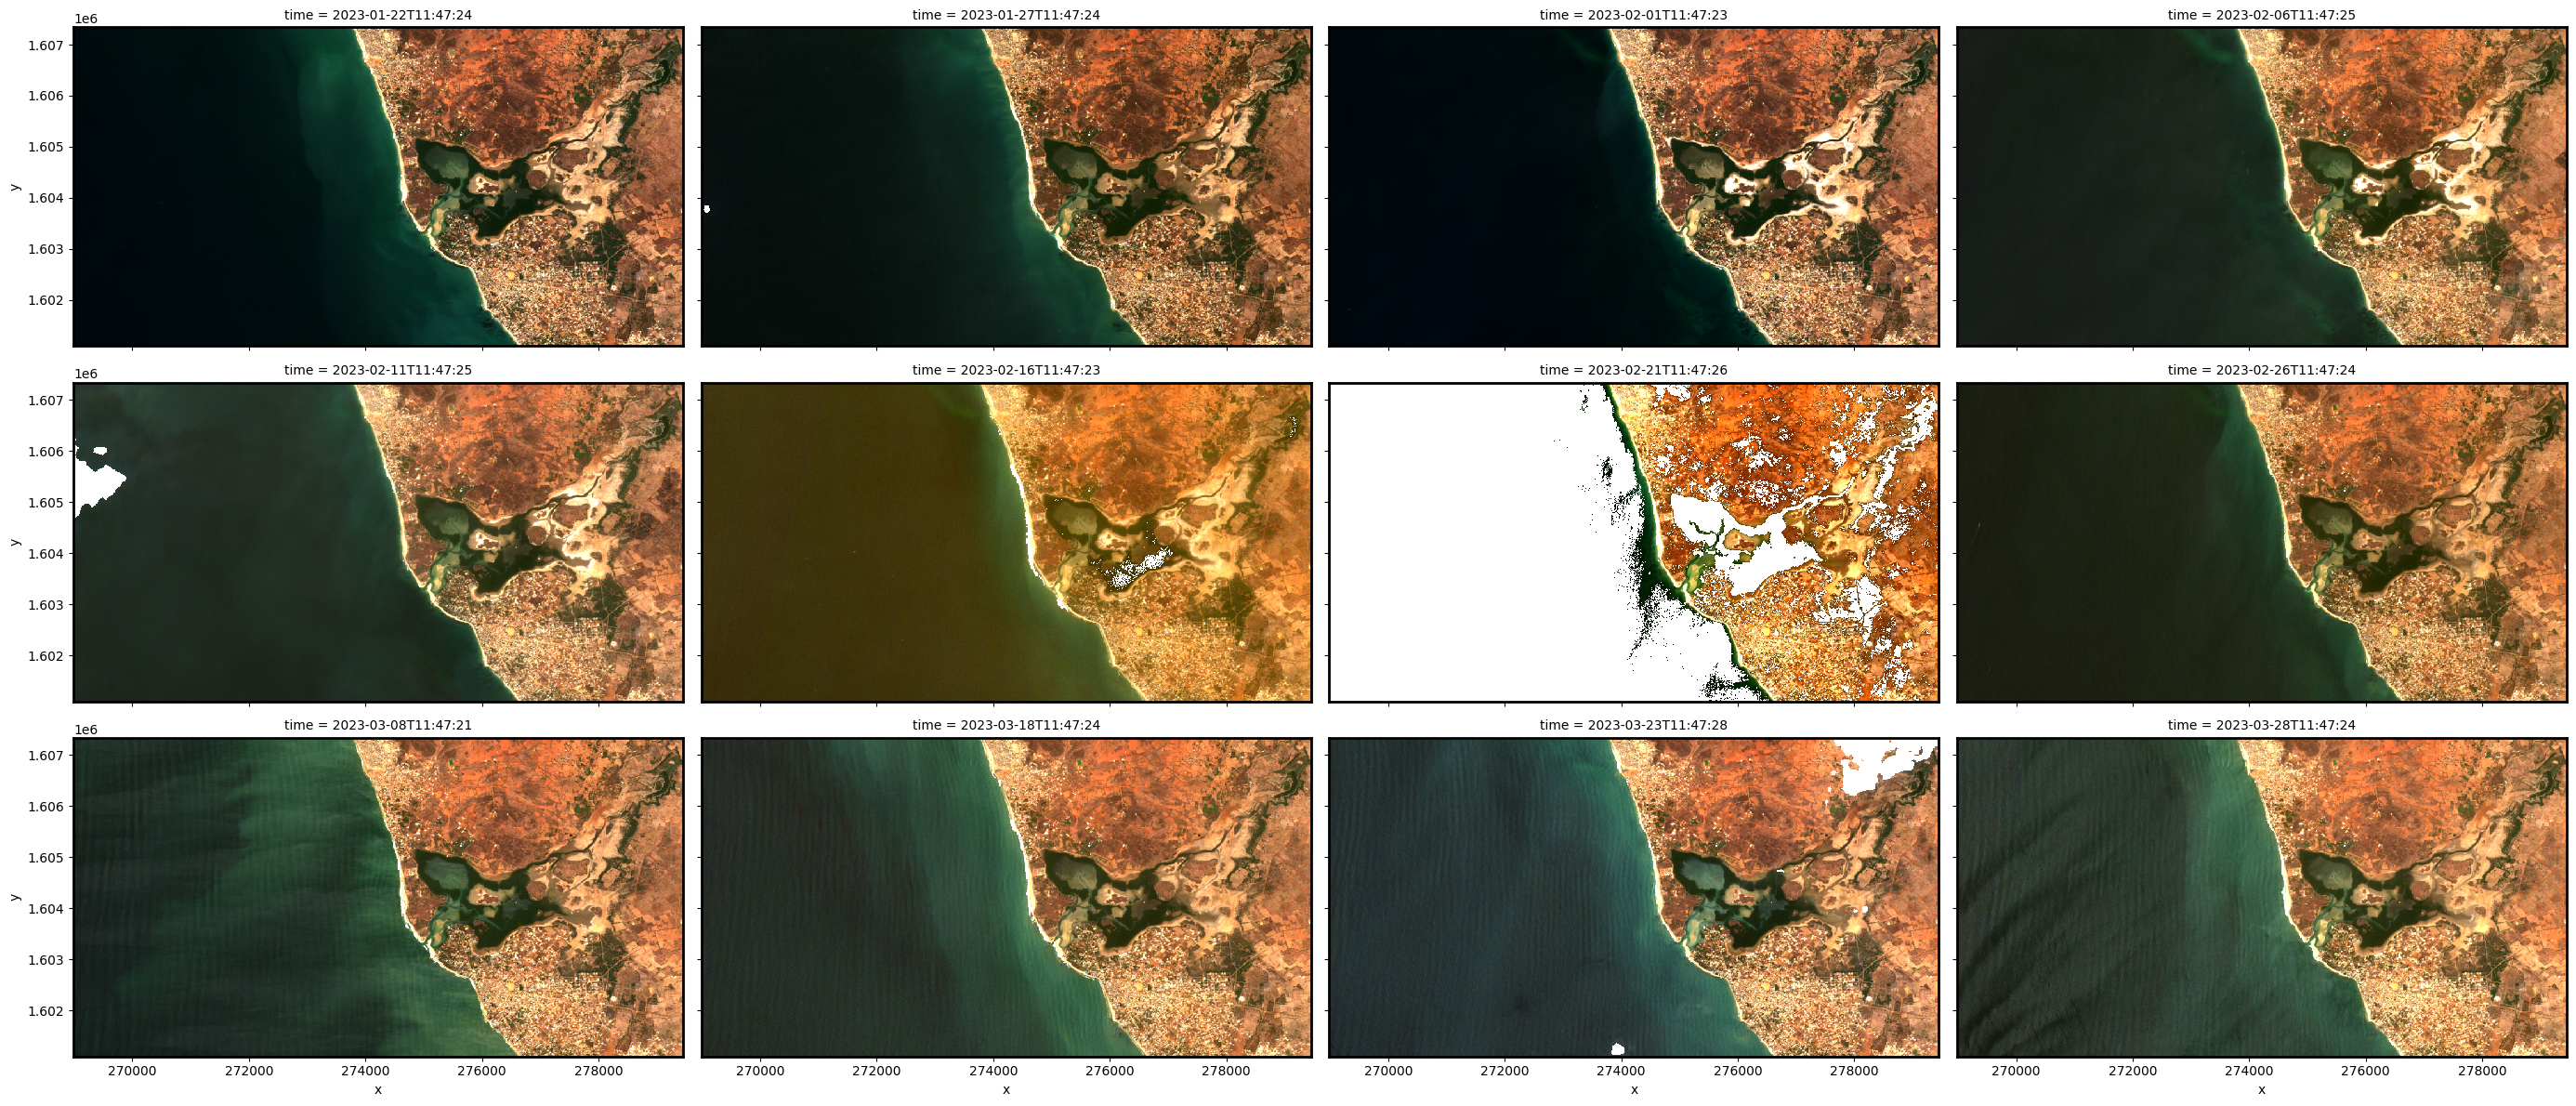

In [34]:
rgb(sentinel_2_ds, bands=["red", "green", "blue"], size = 4,col='time')


In [35]:
water_mask = sentinel_2_ds.NDWI > 0.0

In [41]:
from skimage.measure import find_contours
# Liste pour stocker les lignes de bord extraites
water_edges = []

# Itérer sur chaque pas de temps dans les données Sentinel-2
for time_step in sentinel_2_ds.time:
    # Sélectionner l'image NDWI pour le pas de temps courant
    ndwi_image = sentinel_2_ds.NDWI.sel(time=time_step)

    # Appliquer le masque d'eau
    water_ndwi = ndwi_image.where(water_mask.sel(time=time_step))

    # Trouver les contours des zones d'eau
    contours = find_contours(water_ndwi.values, level=0.0)

    # Convertir les contours en géométries Shapely et les ajouter à la liste
    for contour in contours:
        line = LineString(contour)
        water_edges.append(gpd.GeoDataFrame({'geometry': [line], 'time': [time_step.values]}, crs=sentinel_2_ds.crs))

In [42]:
# Combiner les lignes de bord en un seul GeoDataFrame
water_edges_gdf = gpd.GeoDataFrame(pd.concat(water_edges, ignore_index=True))
# Afficher les lignes de bord extraites
water_edges_gdf.plot()
plt.show()

ValueError: No objects to concatenate

In [ ]:
   from skimage.measure import find_contours
    # Appliquer le masque d'eau
    water_ndwi = ndwi_image.where(water_mask.sel(time=time_step))

    # Trouver les contours des zones d'eau
    contours = find_contours(water_ndwi.values, level=0.0)

    # Vérifier et ajouter les contours extraits à la liste
    if contours:
        for contour in contours:
            line = LineString(contour)
            water_edges.append(gpd.GeoDataFrame({'geometry': [line], 'time': [time_step.values]}, crs=sentinel_2_ds.crs))
    else:
        print(f"No contours found for time step: {time_step.values}")

# Vérifier si des contours ont été trouvés
if water_edges:
    # Combiner les lignes de bord en un seul GeoDataFrame
    water_edges_gdf = gpd.GeoDataFrame(pd.concat(water_edges, ignore_index=True))
    
    # Afficher les lignes de bord extraites
    water_edges_gdf.plot()
    plt.show()
else:
    print("No water edges found in the dataset.")

In [40]:
# Extract the 0 NDWI contour from both timesteps in the NDWI data
contours_gdf = subpixel_contours(da=sentinel_2_ds.NDWI,
                                 z_values=0,
                                 crs=sentinel_2_ds.geobox.crs,
                                 dim='time')

# Plot contours over the top of array
sentinel_2_ds.NDWI.isel(time=4).sel(x = slice(268995.0, 279445.0),
                        y = slice(1601105.0, 1607335.0)).plot(size = 9, cmap = 'RdYlBu')

contours_gdf.plot(ax = plt.gca(), linewidth = 1.5, color = 'black')

Operating in single z-value, multiple arrays mode


TypeError: No numeric data to plot.

In [36]:
print(sentinel_2_ds.NDWI.coords['x'].min().item(), sentinel_2_ds.NDWI.coords['x'].max().item())
print(sentinel_2_ds.NDWI.coords['y'].min().item(), sentinel_2_ds.NDWI.coords['y'].max().item())


268995.0 279445.0
1601105.0 1607335.0


In [37]:
print(sentinel_2_ds.NDWI.sizes['time'])


12


In [38]:
ndwi_selection = sentinel_2_ds.NDWI.isel(time=-1).sel(x=slice(-33000, -32000), y=slice(854000, 853250))
print(ndwi_selection)


<xarray.DataArray 'NDWI' (y: 0, x: 0)>
array([], shape=(0, 0), dtype=float32)
Coordinates:
    time         datetime64[ns] 2023-03-28T11:47:24
  * y            (y) float64 
  * x            (x) float64 
    spatial_ref  int32 32628


In [ ]:
# Extract the 0 NDWI contour from both timesteps in the NDWI data
contours_gdf = subpixel_contours(da=sentinel_2_ds.NDWI,
                                 z_values=0,
                                 crs=sentinel_2_ds.geobox.crs,
                                 min_vertices=10)

# Plot contours over the top of array
# Plot contours over the top of array
sentinel_2_ds.NDWI.isel(time=time_step).sel(x = slice(-33000, -32000),
                        y = slice(854000, 853250)).plot(size = 9, cmap = 'RdYlBu')

contours_gdf.plot(ax = plt.gca(), linewidth = 1.5, color = 'black')


In [ ]:
# Plot the resulting image for the same timestep selected above
sentinel_2_ds.NDWI.plot(cmap='RdBu', size=6, vmin=-0.5, vmax=0.5)
plt.show()

In [ ]:
# Plot the resulting image for the same timestep selected above
sentinel_2_ds.NDVI.plot(cmap='RdYlGn',size=6, vmin=-0.5, vmax=0.5) #cmap='RdYlGn', 
plt.show()

In [ ]:
# Constants for calculating waterbody area
pixel_length = query["resolution"][1]  # in metres
m_per_ha = 100  # conversion from metres to hectares

area_per_pixel = pixel_length**2 / m_per_ha**2

In [ ]:
# Filter the data to contain only pixels classified as water
sentinel_2_ds_waterarea = sentinel_2_ds.where(sentinel_2_ds.NDWI > 0.0)

# Calculate the total water area (in ha)
waterarea = (
    sentinel_2_ds_waterarea.NDWI.count(dim=["x", "y"]) * area_per_pixel).persist()

   # .rolling(time=3, center=True, min_periods=1)
   # .median(skipna=True)


In [ ]:
a = 0.00001
def SSII(sentinel_2_ds):
    return (sentinel_2_ds.red_edge_1) / (sentinel_2_ds.red + a)

In [ ]:
# Calculate the SSII value for Sentinel 2, using water extent to mask
SSII = SSII(sentinel_2_ds_waterarea)

In [ ]:
SSII.plot()

In [ ]:
sentinel_2_ds